# Estimating pose from images using a deep conditional latent variable model

In [1]:
from IPython.display import HTML, display, Markdown, IFrame
from IPython.core.debugger import set_trace
Markdown('Abstract-IRTG-Retreat2019.md')

### Abstract

Pose tracking is the estimation of skeletal poses from video frames. We
investigate pose tracking as a component of biological movement perception. For
this purpose it is important to incorporate temporal and physical constraints
of biological movement. Most state of the art pose tracking algorithms predict
2D keypoint locations from single frames instead, and are thus not suitable for
this purpose.

We assume that movement represented as skeletal joint angles share a latent
representation with its video representation. We implement this assumption as
deep latent variable model (also known as variational autoencoder). The latent
space can be constrained by dynamical systems. Pose tracking in this framework
is done via conditioning the video frames.

We demonstrate the feasibility of the approach using toy data. This is an
important step towards a robust and principled probabilistic pose tracking
algorithm for real world data. The model additionaly allows for the generation
of videos given poses. It is thus an ideal test bed for hypotheses about the
perception of biological movement.


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from deep_lvm_pose_tracking import vae
from deep_lvm_pose_tracking.vae import VAE
from deep_lvm_pose_tracking import toy_data as toy
from deep_lvm_pose_tracking import notebook_utils as nu

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, Subset
device = 'cuda' if torch.cuda.is_available() else "cpu"
print(f'Pytorch: Train with {device}')
device = torch.device(device)

torch.manual_seed(42)
np.random.seed(42)

import sys
import os
from functools import partial


# you might have to start the visdom server manually.
cmd = sys.executable + ' -m visdom.server&'
os.system(cmd)
plotter = nu.VisdomLinePlotter(env_name='main')
print("Started visdom server on port:", plotter.viz.port)

import time
t0 = time.time()

Pytorch: Train with cuda
Started visdom server on port: 8097


## Problem statement

*Pose estimation* is the inverse problem to the following forward problem[<sup>1</sup>](#fn1):
With a specified hierarchy, we can construct high-dimensional ($D_{\text{img}}>4000$ dimensions) images from a (in comparison) low-dimensional ($D_{\text{pose}} \approx 60$ dimensions for a simplified human skeleton) input. 
Many pose estimation algorithms predict 2D keypoint annotations and can therefore not use constraints given by the **body's hierarchical structure**.

The Problem is thus finding a "function":
\begin{align}
f: \mathbb{R}^{D_{\text{img}}}\rightarrow \mathbb{R}^{D_{\text{pose}}}
\end{align}

This is an ill-posed problem due to ambiguity of images: an image can correspond to many poses. $f$ is therefore not a "true" function because it maps one element to many. Human observers do not encounter this problem in practice, because they always observe time series, and correspondingly biological movement perception is more closely related to *pose tracking*. Here we can make use of  constraints given by **temporal dependencies** in pose and image data: the pose estimated at one time point is relies on prior information. 

Furthermore **uncertainty should be handled in an (approximately) optimal manner** to make pose tracking more robust: ambigous poses should be detected, as well as images very unlike those encountered during training (anomaly detection).

Recently, convolutional neural networks and massive amounts of 2D-pose annotated image data enabled successful pose estimation for single frames. Yet, the performance is not robust enough for medical or scientific applications.  We argue that for further improvement in pose tracking it is necessary to make use of the all previous constraints:

1.  temporal dependencies: one pose at one time point is typically similar as the pose of the previous time point
2. hierarchical rigid body structure of the body
3. handle uncertainty in approximately optimal manner

Our approach is loosely insprired by the most reliable (yet not most precise) pose estimation system: the human. 
Here, research has shown that pose is generated from a even lower dimensional manifold with $D_{\text{latent}}=?$ dimensions. 

\begin{align}
\text{dec}_\text{pose}: \mathbb{R}^{D_{\text{latent}}}\rightarrow\mathbb{R}^{D_{\text{pose}}}
\end{align}

We propose that the latent space of image and pose is identical, giving rise to a shared representation of both. 

\begin{align}
\text{dec}_\text{img}: \mathbb{R}^{D_{\text{latent}}}\rightarrow\mathbb{R}^{D_{\text{img}}}
\end{align}

We build a model implementing this assumption to investigate this hypothesis.
We will demonstrate, that a conditional deep latent variable model (also known as conditional variational autoencoder[<sup>2</sup>](#fn2)) satisfies the required constrained and is suitable to be applied to the problem of pose tracking.

<span id="fn1"> <sup>1</sup> <sup><sub>In analogy to "perception as inverse computer graphics" perspectives this would correspond to "biological movement perception as inverse computer animation".  (We do not necessarily adopt this strong position). <sub><sup></span>
    
<span id="fn2"> <sup>2</sup> <sup><sub>We prefer the name deep latent variable model to emphasize the model and not the superficial similarity to autoencoders. <sub><sup></span>

## The problem in its simplest form: introducing hierarchical toy data

To make the problem as simple as possible, we get rid of additional degrees-of-freedom by removing camera transformation and projection and consider only a hierarchy in 2D with a pose specified by 3 angles. We choose to generate the images by visualizing only the $(x, y)$ coordinates of the joints.

We first try if we can estimate poses without ambigous images. This must be possible on single frames, without time dependency. We do this by constraining the last two angles to be in $\left(-\frac{\pi}{2}, \frac{\pi}{2}\right)$.


In [3]:
IFrame('../media/toy_data_video.html', width=450, height=350)

In [4]:
N = 360000
batch_size = 128
d = 64  # image edge length
img_shape = (d, d)

bone_lengths, key_marker_width = nu.make_bonelengths_and_width()
poses = nu.make_poses(N=N)

# generate training data
h = toy.HierarchyImages(angles=poses, bone_lengths=bone_lengths,
                        key_marker_width=key_marker_width,
                        img_shape=img_shape)

# data loader for easy batching
data_loader = DataLoader(h, batch_size=batch_size, shuffle=True, num_workers=4,
                         drop_last=True)

poses_val = nu.make_poses(N=N//10)

h_val = toy.HierarchyImages(angles=poses_val, bone_lengths=bone_lengths,
                            key_marker_width=key_marker_width,
                            img_shape=img_shape)

val_loader = DataLoader(h_val, batch_size=batch_size, shuffle=False, num_workers=4,
                        drop_last=True)

# dataloader dictionary with reduced validation set size
dataloader = {'train': data_loader,
              'val': DataLoader(torch.utils.data.Subset(h_val, np.random.choice(range(len(h_val)), size=N//5)),
                               drop_last=True, batch_size=batch_size, num_workers=4),
              'pretrain': DataLoader(torch.utils.data.Subset(h_val, np.random.choice(range(len(h_val)), size=N//5)),
                               drop_last=True, batch_size=batch_size, num_workers=4)
             }

# bake notebook specific functions
plot_sample_grid = partial(nu.plot_sample_grid, img_shape=img_shape)
pose_to_image = partial(nu.pose_to_image, bone_lengths=bone_lengths, d=d)
# h.plot_image(np.random.randint(0, len(poses)))

## Deep Latent Variable Model a.k.a. Variational Autoencoder

Variational Autoencoders have been independently developed by:

1) Kingma, Diederik P., and Max Welling. “Auto-Encoding Variational Bayes.” ArXiv:1312.6114 [Cs, Stat], December 20, 2013. http://arxiv.org/abs/1312.6114.

2) Rezende, Danilo Jimenez, Shakir Mohamed, and Daan Wierstra. “Stochastic Backpropagation and Approximate Inference in Deep Generative Models.” ArXiv:1401.4082 [Cs, Stat], January 16, 2014. http://arxiv.org/abs/1401.4082.

In this notebook I use the notation of Kingma, Welling 2013.

#### The model

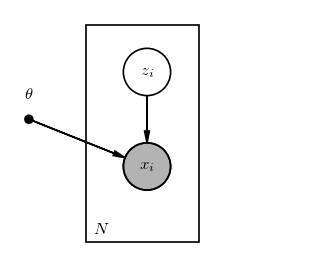

In [5]:
pgm = nu.make_vae_graph()
ax = pgm.render(dpi=120)

In variational autoencoders, the latent variables are drawn from a  normal prior distribution with zero mean and diagonal unit variance:

$z_i\sim\mathcal{N}(0, 1)$.

The likelihood is a distribution, for example normal, parameterized by neural networks with weights $\theta$:

$p(x_i \mid z_i) = \mathcal{N}(x_i \mid  \mu(z_i), \sigma(z_i)^2)$

$\text{NN}(z_i ;\theta) = (\mu(z_i), \sigma(z_i)^2)$

Or more generally for any linear exponential family distribution:

$p_\theta(x_i \mid z_i) = \frac{1}{Z(\eta(z_i))}\exp\left(\theta(z_i)^T \cdot \tau(x_i)\right)$

$\text{NN}(z_i ;\theta) = \eta(z_i)$

The likelihood is in this context often called **decoder**, because it decodes the output $x$ from code $z$, or more traditionally **observation model**.

#### The objective

We want to maximize the marginal likelihood of images $x_i$ to train our model:

$p_\theta(x_i) = \int p_\theta(x_i|z_i)p(z) dz_i$.

If $p_\theta(x_i|z_i)$ is a density parameterized by a neural network, we can not solve this integral analytically.
We can still sample from $z_i$ to estimate $p_\theta(x_i)$, but $x_i$ is super-high-dimensional, thus $p_\theta(x_i|z_i)$ will be practically zero for all for most samples of $z_i$, if we don't sample in a smart manner.

#### Variational approximation

Sampling $z_i$ from the posterior $p(z_i|x_i)$ would result in the most likely images, but we do not have the posterior.
Let's introduce an approximation $q(z_i)$ to the posterior such that $\mathcal{KL}(q(z_i)||p(z_i|x_i))$ is small. We choose a normal distribution with $\mu, \sigma^2$ parameterized by a neural network with parameters $\phi$. The approximate posterior is often called **encoder**, or **recognition model**:

\begin{align}
\mathcal{KL}[q_\phi(z_i|x_i)||p_\theta(z_i|x_i)] &= \mathbb{E}_{q_\phi(z_i|x_i)}[\log q_\phi(z_i|x_i) - \log p_\theta(z_i|x_i)]\\
&= \mathbb{E}_{q_\phi(z_i|x_i)}[\log q_\phi(z_i|x_i) - \log p_\theta(x_i|z_i) - \log p(z_i)] + \log p(x_i)\\
&= \mathbb{E}_{q_\phi(z_i|x_i)}[- \log p_\theta(x_i|z_i)] + \mathcal{KL}[q_\phi(z_i|x_i)|| p(z_i)] + \log p(x_i)
\end{align}

\begin{align}
\Rightarrow\log p(x_i) - \mathcal{KL}[q_\phi(z_i|x_i)||p_\theta(z_i|x_i)] &= \mathbb{E}_{q_\phi(z_i|x_i)}[\log p_\theta(x_i|z_i)] - \mathcal{KL}[q_\phi(z_i|x_i)|| p_\theta(z_i)]\\
\mathcal{L}(\theta, \phi; x_i) &= \mathbb{E}_{q_\phi(z_i|x_i)}[\log p_\theta(x_i|z_i)] - \mathcal{KL}[q_\phi(z_i|x_i)|| p(z_i)]
\end{align}

Thus, maximizing the evidence lower bound is a trade off between increasing the likelihood of the data, while keeping the posterior as close to the prior as possible.
The KL-divergence between approximate posterior and prior is analiytically tractable due to our choices of prior and approximate posterior.
The exptected log-likelihood could be approximated by sampling in the following manner:

\begin{align}
\mathbb{E}_{q_\phi(z_i|x_i)}[\log p_\theta(x_i|z_i)] &= \frac{1}{S} \sum_{s=0}^{S-1}\log p_\theta(\hat x_i^{(s)}|\hat z_i^{(s)})
\end{align}

#### Updating the weights using the log-derivative-trick

The approximate gradients for updating the decoder network's weights $\theta$ is:

\begin{align}
\nabla_\theta\mathbb{E}_{q_\phi(z_i|x_i)}[\log p_\theta(x_i|z_i)] &= \nabla_\theta \int_{z_i}dz_i q_\phi(z_i|x_i) \log p_\theta(x_i|z_i)\\
&=  \int_{z_i}dz_i q_\phi(z_i|x_i) \nabla_\theta\log p_\theta(x_i|z_i)\\
&=  \mathbb{E}_{q_\phi(z_i|x_i)} \left[\nabla_\theta\log p_\theta(x_i|z_i)\right]
\end{align}

We can now use sampling to approximate this expectation because it is well behaved: the variance of the gradient is low.

\begin{align}
\frac{\partial}{\partial \phi}\mathbb{E}_{q_\phi(z_i|x_i)}[\log p_\theta(x_i|z_i)] &= \frac{\partial}{\partial \phi} \int_{z_i}dz_i q_\phi(z_i|x_i) \log p_\theta(x_i|z_i)\\
&=\int_{z_i}dz_i q_\phi(z_i|x_i) \frac{\partial}{\partial \phi}\log q_\phi(z_i|x_i)  \log p_\theta(x_i|z_i)\\
&=\mathbb{E}_{q_\phi(z_i|x_i)} \left[ \frac{\partial}{\partial \phi}\log q_\phi(z_i|x_i)  \log p_\theta(x_i|z_i) \right]
\end{align}
While we derived an unbiased estimator of the gradient, it is not practical because the variance is very high. The likelihood for images will be very low, especially before training. The log will then be a huge negative number, while the gradient changes signs. Samples will therefore yield very high or very low numbers, and many samples are needed for convergence to the true value. 

This motivates the alternative method of constructing an estimator which is differentiable w.r.t. $\theta$ **and** $\phi$.

#### Stochastic Gradient Variational Bayes (SGVB) estimator: updating the weights using the reparameterization trick

Given our choice of $q_\phi(z_i|x_i) = \mathcal{N}(z_i; \mu(x_i), \sigma^2(x_i))$ it is natural to reparameterize $z$: Use $p(\varepsilon)=\mathcal{N}(\varepsilon; 0, 1)$ and use the mapping $z_i\sim g_\phi(x_i, \varepsilon)=\mu(x_i)+\varepsilon\cdot\sigma^2(x_i)$ to generate samples:

\begin{align}
\mathbb{E}_{q_\phi(z_i|x_i)}[\log p_\theta(x_i|z_i)] &= \mathbb{E}_{p(\varepsilon)}[\log p_\theta(x_i|g_\phi(x_i, \varepsilon))]\\
 &= \int d\varepsilon p(\varepsilon) \log p_\theta(x_i|g(x_i, \varepsilon))\\
 &\approx \frac{1}{S}\sum_{s=0}^{S-1} \log p_\theta(x_i|g(x_i, \varepsilon^{(s)}))
\end{align}

Computing the gradient $\nabla_\phi$ of this estimator is now not a problem anymore, because we can pull the operator inside the expectation without relying on the log-derivative trick.
Furthermore each term defines a simple forward pass: the decoder gets input and its output is combined with the sampled $\varepsilon$ into the latent variable $z$. The encoder then uses the latent variable to reconstruct the input. The sampling is thus externalized, and we can use **backpropagation** to compute all the gradients simultanously:

<img src='../media/vae_graph.svg' alt='Drawing' style='width: 900px'>

### Bernoulli observation model

\begin{align}
\log P(x_i|z) = x_i\log(\text{NN}(z))+(1-x_i)\log(1-\text{NN}(z))
\end{align}

In [6]:
# These parameters are not optimized yet
latent_dim = 3
hidden = 600
beta = 1

model = VAE(input_dim=d**2, latent_dim=latent_dim,
            hidden=hidden).to(device)

Open [Visdom Server](//localhost:8097) to monitor training process.

In [7]:
loss_func = partial(vae.loss_function, likelihood='bernoulli')
val_loss = vae.fit(model, dataloader, epochs=1, device=device, beta=beta, stop_crit=0, plotter=plotter)


train loss: 6.92E-07
val loss: 1.91E-03


#### Generating images from noise

The plots show $p(x|z)$ with $z \sim \mathcal{N}(0, 1)$.
Even though there is room for improvement (e.g. changing the output activation function), I think the network learned the hierarchical constraints:

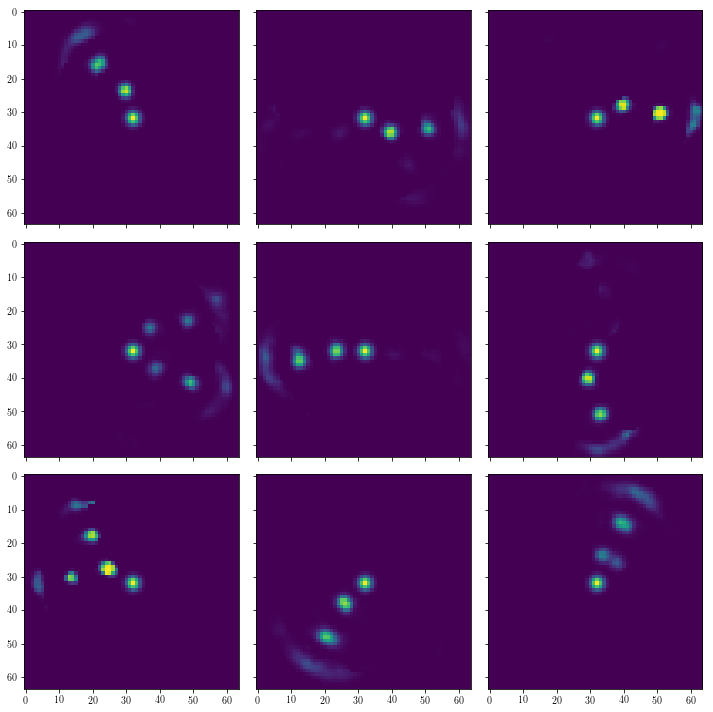

In [8]:
plot_sample_grid(nu.draw_samples(model))

### Traversing the latent space

Maybe the 3 latent dimensions correspond to the angles already?
$\rightarrow$ Not quite...

In [9]:
traverser = nu.LatentTraverser(model)
anims = traverser.get_anims(range(3))
vids = [anim.to_html5_video() for anim in anims]

In [10]:
for i, vid in enumerate(vids):
    display(Markdown(f"#### Latent $z_{i}$"))
    display(HTML(vid))

#### Latent $z_0$

#### Latent $z_1$

#### Latent $z_2$

## Deep conditional generative model (Conditional VAE)

This model has been introduced in: 
[Sohn, Kihyuk, Honglak Lee, and Xinchen Yan. “Learning Structured Output Representation Using Deep Conditional Generative Models” 2015.](https://papers.nips.cc/paper/5775-learning-structured-output-representation-using-deep-conditional-generative-models.pdf)

### Generating poses given image

We see that the VAE can already learn a useful low-dimensional representation of the toy data. It should therefore be possible to get the pose angles from this latent variable. For this we have to adapt our model:

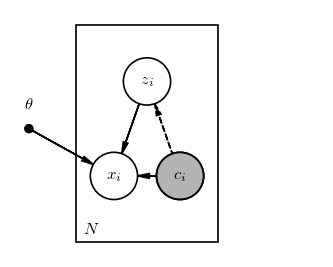

In [11]:
pgm = nu.make_cvae_graph()
ax = pgm.render(dpi=120)

Here, $x_i$ is the pose (specified by joint angles), and $c_i$ is the observed image, which is additional input to the encoder and decoder.

\begin{align}
\mathcal{L}(\theta, \phi; x_i) &= \mathbb{E}_{q_\phi(z_i|x_i, c_i)}[\log p_\theta(x_i|z_i, c_i)] - \mathcal{KL}[q_\phi(z_i|x_i, c_i)|| p(z_i)]
\end{align}

<img src='../media/cvae_graph.svg' alt='Drawing' style='width: 900px'>

Estimating poses from images by training a shared latent variable model and then conditioning on the pose has some advantages:

- Errorbars: it's a probabilistic model
- Anomaly detection: $\mathcal{KL}(q(z|x)|\mathcal{N}(0, 1))$ will be large if input is very different than training samples

In [12]:
latent_dim = 1 # one dimension is enough for this task!
weight_fn = None
beta = 1
cvae = vae.cVAE(input_dim=3, condition_dim=d**2, latent_dim=latent_dim, hidden=600, likelihood='bernoulli',
           condition_on='image').to(device)

In [13]:
loss_func = partial(vae.joint_loss, likelihood='bernoulli')
hist = vae.fit(cvae, dataloader, epochs=1, device=device, weight_fn=weight_fn,
           loss_func=loss_func,
           conditional=True, plotter=plotter, stop_crit=0, beta=beta)


train loss: 4.01E-08
val loss: 1.15E-04


Ground truth:
 [-142.45188126   34.72111209  -27.95601881]
Pose recovered from image:
 [-139.15295   32.68641  -25.44292]
Error:
 [-3.29892716  2.03470309 -2.51309813]


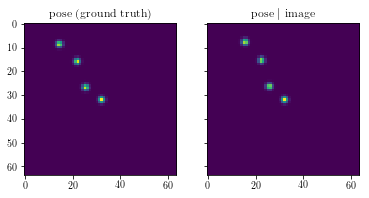

Ground truth:
 [151.22253926   5.71127895 -35.60190388]
Pose recovered from image:
 [152.93018     4.1836667 -33.617146 ]
Error:
 [-1.70763652  1.52761225 -1.98475834]


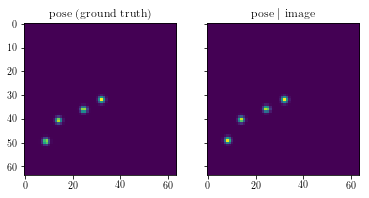

Ground truth:
 [  1.31964869 -17.05410072  24.28532796]
Pose recovered from image:
 [  4.8327827 -19.36366    29.389072 ]
Error:
 [-3.51313406  2.3095601  -5.10374446]


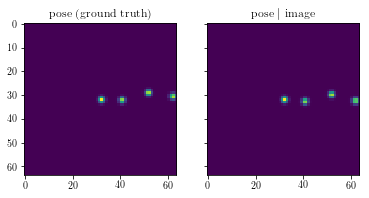

Ground truth:
 [-114.27595069   32.33021029   -4.17555956]
Pose recovered from image:
 [-111.84715      31.247456      0.42870283]
Error:
 [-2.42879798  1.08275469 -4.60426239]


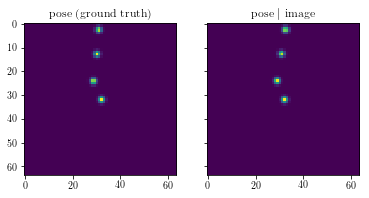

Ground truth:
 [-38.02719658 -44.28749148   9.41094481]
Pose recovered from image:
 [-36.124172 -44.873474  10.402164]
Error:
 [-1.90302437  0.58598264 -0.99121965]


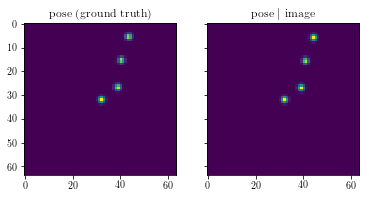

Ground truth:
 [151.98473969   4.31933485  25.5705322 ]
Pose recovered from image:
 [151.91199     3.9088798  29.248482 ]
Error:
 [ 0.07275238  0.41045509 -3.67794956]


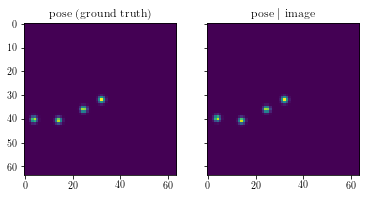

Ground truth:
 [124.05072654 -24.6133645  -33.92479729]
Pose recovered from image:
 [126.251686 -26.504677 -31.789766]
Error:
 [-2.20095956  1.89131232 -2.13503098]


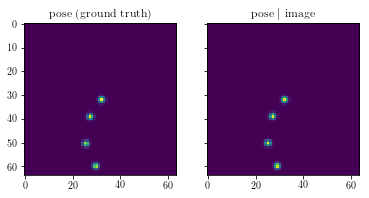

Ground truth:
 [-118.52280044   -8.25398565   40.60444939]
Pose recovered from image:
 [-117.914154   -8.200436   42.23387 ]
Error:
 [-0.60864638 -0.05355001 -1.62942207]


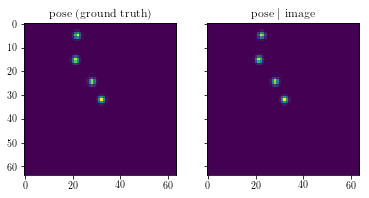

Ground truth:
 [-53.68887098  42.82644734  39.4694079 ]
Pose recovered from image:
 [-51.529514  42.91702   39.983517]
Error:
 [-2.15935666 -0.09057155 -0.51410879]


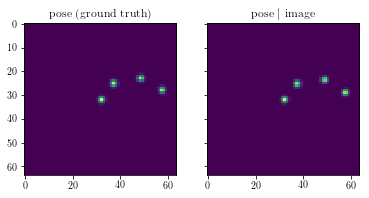

In [22]:
# draw random poses from validation set
idxs = np.random.choice(range(len(h_val)), size=9)
poses = np.array([h_val[i]['angles'] for i in idxs])
poses_degree = nu.un_normalize(poses)

# draw corresponding images from validation set
imgs = np.array([h_val[i]['image'] for i in idxs])
# generate poses from noise given images
samples = nu.draw_samples(cvae, imgs.reshape(9, d**2))

poses_recovered = nu.un_normalize(samples[:, d**2:])
np.std(poses_recovered-poses_degree, axis=0, ddof=1)

for i in range(9):
    label = samples[i, d**2:]
    pose_true = poses_degree[i]
    pose_recovered = nu.un_normalize(label)
    print('Ground truth:\n', pose_true)
    print('Pose recovered from image:\n', pose_recovered)
    print('Error:\n', pose_true-pose_recovered)
    fig, ax = plt.subplots(ncols=2, sharey=True)
    ax[0].set_title('pose (ground truth)')
    ax[0].imshow(pose_to_image(poses[i]))
    ax[1].set_title('pose $\mid$ image')
    ax[1].imshow(pose_to_image(label))
    plt.show()

## $\rightarrow$ It is possible to predict pose by conditioning on the image!
### (... at least for this very constrained toy data)

In [15]:
from datetime import timedelta
T = time.time()
td = timedelta(seconds=T-t0)
print('Total runtime:', str(td).split('.')[0])

Total runtime: 0:02:55
